In [2]:
from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model_id = "openai/clip-vit-base-patch32"
cache_dir = "../models/"

model = CLIPModel.from_pretrained(model_id, cache_dir=cache_dir)
processor = CLIPProcessor.from_pretrained(model_id, cache_dir=cache_dir)

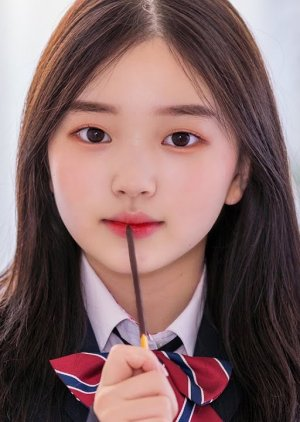

In [53]:
# posterpath = "../data/posters/not_released_yet/27319-the-golden-hairpin_k644m_4c.jpg"
posterpath = "../data/posters/714369-pepero-was-taken-away-on-pepero-day_e4J7K_4c.jpg"
img = Image.open(posterpath)
display(img)

In [54]:
labels = ['China', 'Hong Kong', 'Japan', 'Philippines', 'South Korea', 'Taiwan', 'Thailand']

with torch.no_grad():
    
    inputs = processor(text=labels, images=img, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [55]:
labels[probs.argmax()], probs

('South Korea',
 tensor([[0.0809, 0.0207, 0.2415, 0.0037, 0.5714, 0.0639, 0.0181]]))